### Part 1: Data Pre-processing

```shell
pip install -U kardiasclean
```

#### Step 1: Load Data from CSV

Load csv and merge them with pandas to create a dataframe with repeated patient data but unique surgical procedure per patient.

In [30]:
import pandas as pd
import kardiasclean
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [31]:
# load
patient_df = pd.read_csv("../database/clean2/db_patient.csv")
diagnosis_per_patient_df = pd.read_csv("../database/clean2/db_patient_diagnosis_main.csv")
patient_df.count()

patient_id        1003
gender            1003
age_days          1003
weight_kg         1003
height_cm         1003
cx_previous       1003
date_birth        1003
date_procedure    1003
rachs             1003
stay_days         1003
expired           1003
dtype: int64

In [32]:
# drop null values
diagnosis_per_patient_df.dropna(inplace=True)
diagnosis_per_patient_df

,patient_id,diagnosis_main
0,0,Comunicacion interauricular secundum
1,1,Comunicacion interauricular secundum
2,2,Comunicacion interauricular secundum
3,3,Comunicacion interauricular secundum
4,4,Comunicacion interauricular secundum
...,...,...
1994,1035,Conducto arterioso permeable
1995,1037,Tetralogia de Fallot TOF -Sindrome de valvula ...
1996,1037,Estenosis de la arteria pulmonar
1997,1037,Comunicacion interventricular


In [33]:
diagnosis_per_patient_df.count()

patient_id        1997
diagnosis_main    1997
dtype: int64

In [34]:
# merge
df = pd.merge(patient_df, diagnosis_per_patient_df)
print(df.columns)
df[5:10]


Index(['patient_id', 'gender', 'age_days', 'weight_kg', 'height_cm',
       'cx_previous', 'date_birth', 'date_procedure', 'rachs', 'stay_days',
       'expired', 'diagnosis_main'],
      dtype='object')


,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,date_birth,date_procedure,rachs,stay_days,expired,diagnosis_main
5,5,1,2888,34.4,134.0,0,2004-08-31,2012-08-09,2,2,0,Comunicacion interventricular Tipo 2 perimembr...
6,5,1,2888,34.4,134.0,0,2004-08-31,2012-08-09,2,2,0,Estenosis aortica subvalvular
7,6,0,3828,37.0,141.0,0,2002-04-02,2012-09-22,2,2,0,Comunicacion interventricular Tipo 2 perimembr...
8,7,0,1583,13.5,102.0,0,2008-06-05,2012-09-29,1,2,0,Comunicacion interauricular secundum
9,8,1,3549,37.0,137.0,0,2002-04-12,2012-10-13,2,5,0,Comunicacion interventricular Tipo 1 infundibular


#### Step 2: High and Low Frequency Categories (Exploratory)

We can play with the QUANTILE variable to find a good signal to noise ratio (assuming that the low frequency values can add noise to the model). This is only so we can get an idea of how much data is binned in the next step.

In [35]:
QUANTILE = 0.85
low, high = kardiasclean.perform_frequency_split_quantile(df['diagnosis_main'], QUANTILE)
print(kardiasclean.evaluate_distribution(high, low))

Total data (repeated): 1997
--------------------
Unique high frequency data: 171
Unique low frequency data: 656
--------------------
Total high frequency data: 1341
Total low frequency data: 656
--------------------
Percentage of high data: 67.15%
Percentage of low data: 32.85%
--------------------
Summary
--------------------
From 1997 data, 171 account for 67.15% of the total count.



#### Step 3: Bin Low Frequency Data

Convert all low frequency categorical variables to "Other".

In [36]:
df['diagnosis_main'] = kardiasclean.perform_binning_quantile(df['diagnosis_main'], QUANTILE)
df['diagnosis_main']

0       Comunicacion interauricular secundum
1       Comunicacion interauricular secundum
2       Comunicacion interauricular secundum
3       Comunicacion interauricular secundum
4       Comunicacion interauricular secundum
                        ...                 
1992            Conducto arterioso permeable
1993                                   Other
1994                                   Other
1995           Comunicacion interventricular
1996             Comunicacion interauricular
Name: diagnosis_main, Length: 1997, dtype: object

#### Step 4: Deal with dates
We are going to replace the date of birth and date of procedure with a new value that will be the difference of the two so we can use it as a number in our model.

**NOTE**: The age_days and date_delta have a linear relationship so maybe we can drop one in favor of the other.

,age_days,date_delta
0,3942,3882
1,3202,3338
2,3147,3193
3,4005,3975
4,5289,5131


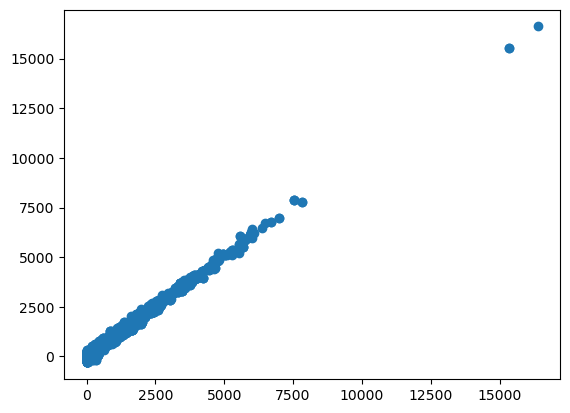

In [37]:
df['date_delta'] = (
    pd.to_datetime(df['date_procedure']) - pd.to_datetime(df['date_birth'])
).dt.days
plt.scatter(df['age_days'], df['date_delta'])
df[0:5][['age_days', 'date_delta']]

In [38]:
# Drop unnecessary dates / ages
df = df.drop(columns=["date_birth", "date_procedure", 'age_days'])
df.to_csv("../database/patient_no_dates.csv", index = False)
df[5:10]

,patient_id,gender,weight_kg,height_cm,cx_previous,rachs,stay_days,expired,diagnosis_main,date_delta
5,5,1,34.4,134.0,0,2,2,0,Comunicacion interventricular Tipo 2 perimembr...,2900
6,5,1,34.4,134.0,0,2,2,0,Estenosis aortica subvalvular,2900
7,6,0,37.0,141.0,0,2,2,0,Comunicacion interventricular Tipo 2 perimembr...,3826
8,7,0,13.5,102.0,0,1,2,0,Comunicacion interauricular secundum,1577
9,8,1,37.0,137.0,0,2,5,0,Comunicacion interventricular Tipo 1 infundibular,3837


#### Step 5: Encode Categorical Data and Merge

We are going to encode the categorical data and merge it with the original.

**NOTE**:In the case of "Other", we get values like 2 or 3 because they may have had multiple procedures that are are low frequency, so patient_id and "Other" columns are repeated. 

This means that we must group our data by patient_id and get the mean value for each column, as all the values are numeric.

In [39]:
encoded = kardiasclean.perform_matrix_encoding(df['diagnosis_main'], df['patient_id'], append_name=False)
merged_df = pd.merge(df, encoded).drop("diagnosis_main", axis=1)
merged_df[['patient_id', 'Other']]

,patient_id,Other
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
1992,1035,3
1993,1037,2
1994,1037,2
1995,1037,2


#### Step 6: Group all Duplicated Patients
In this case, we want to group by patient_id so one row can have a value in multiple categorical columns (Note that "Other" can be higher than 1). This is optional as we could decide to not consider overlapping procedures.

In [40]:
final_df = merged_df.groupby("patient_id").mean()
print("Before merging", merged_df.shape)
print("After merging", final_df.shape)
final_df.columns

# final_df.to_csv("../database/clean_diagnosis_main.csv", index= True)

Before merging (1997, 181)
After merging (1003, 180)


Index(['gender', 'weight_kg', 'height_cm', 'cx_previous', 'rachs', 'stay_days',
       'expired', 'date_delta', 'Comunicacion interauricular secundum',
       'Comunicacion interventricular Tipo 2 perimembranosa',
       ...
       'Comunicacion interatrial tipo ostium secundum',
       'Atresia pulmonar con comunicacion interventricular',
       'Dextrocardia/ Dextroapex', 'PO de FBT', 'Ramas pulmonares confluentes',
       'Atresia tricuspidea IB',
       'Comunicacion interventricular no relacionada', 'HAP',
       'ventriculo izquierdo borderline',
       'Conducto arterioso permeable de 27 mm'],
      dtype='object', length=180)

## Part 2: Questions and ML

We are going to use questions to pick our ML models.

#### Step 1: Target and Features

##### **Question**: Having patient data, most common and uncommon main diagnosis, what is the probability of having a patient with a Common Diagnosis?


In [51]:
# Import csv and drop diagnosis_main from patient_no_dates
main_df = pd.read_csv("../database/diagnosis_main_other.csv")
patient_df = pd.read_csv("../database/patient_no_dates.csv")
patient_df = patient_df.drop(columns=["diagnosis_main", "expired"])
patient_df

,patient_id,gender,weight_kg,height_cm,cx_previous,rachs,stay_days,date_delta
0,0,0,35.00,134.0,0,1,2,3882
1,1,1,18.00,117.0,0,1,2,3338
2,2,0,22.00,120.0,0,1,2,3193
3,3,0,42.00,147.0,0,1,2,3975
4,4,0,40.00,157.0,0,1,3,5131
...,...,...,...,...,...,...,...,...
1992,1035,1,3.23,50.0,0,4,-44214,14
1993,1037,1,3.80,53.5,0,3,-44220,68
1994,1037,1,3.80,53.5,0,3,-44220,68
1995,1037,1,3.80,53.5,0,3,-44220,68


In [52]:
# Merge df
df = pd.merge(patient_df, main_df)
df[5:10]

,patient_id,gender,weight_kg,height_cm,cx_previous,rachs,stay_days,date_delta,diagnosis_main
5,5,1,34.4,134.0,0,2,2,2900,Other
6,5,1,34.4,134.0,0,2,2,2900,Estenosis aortica subvalvular
7,5,1,34.4,134.0,0,2,2,2900,Other
8,5,1,34.4,134.0,0,2,2,2900,Estenosis aortica subvalvular
9,6,0,37.0,141.0,0,2,2,3826,Other


In [53]:
# Target
y = df["diagnosis_main"].map(lambda x: 1 if x != "Other" else 0).values # create binary target
# Features
X = df.drop(["diagnosis_main"], axis=1).values
print("Common Diagnosis:", y[y==0].shape[0])
print("Other:", y[y==1].shape[0])

Common Diagnosis: 4158
Other: 1479


In [54]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Normalize
scaler = StandardScaler()
X_scaler = scaler.fit(X)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
print(X_train_scaled.shape, y_train.shape)
X_train_scaled

(4227, 8) (4227,)


array([[ 0.44672558,  0.90173344, -0.67267012, ...,  2.7921541 ,
         0.17429463, -0.93136581],
       [ 1.27399891, -1.10897518, -0.58491061, ..., -0.54882927,
         0.14941717, -0.42397065],
       [-0.3421511 ,  0.90173344,  1.22147256, ..., -0.54882927,
         0.14849579,  1.70113593],
       ...,
       [ 0.70153973,  0.90173344, -0.5044644 , ..., -1.38407511,
         0.14880291, -0.45650486],
       [-1.888489  , -1.10897518,  2.75726392, ..., -1.38407511,
         0.14788153,  2.37812429],
       [ 1.21116802,  0.90173344,  1.8357891 , ...,  0.28641657,
         0.14834222,  2.85644632]])

#### Step 2: Neural Network
We pick a model depending on our target.

https://albertovaldez5.gitlab.io/data-week-19/build/deeplearning.html#work-with-hyperparameters

In [55]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
dim = len(X_train_scaled[0])
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=60, activation="tanh", input_dim=dim))
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=60, activation="linear"))
# Third hidden layer
nn.add(tf.keras.layers.Dense(units=60, activation="relu"))
# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 60)                540       
                                                                 
 dense_9 (Dense)             (None, 60)                3660      
                                                                 
 dense_10 (Dense)            (None, 60)                3660      
                                                                 
 dense_11 (Dense)            (None, 1)                 61        
                                                                 
Total params: 7,921
Trainable params: 7,921
Non-trainable params: 0
_________________________________________________________________


#### Step 3: Train and Predict

We compile and fit the model. Then make a prediction.

In [56]:
# Train
optimizer = tf.keras.optimizers.Adam(0.0001) # set learning rate
# LOSS: binary_crossentropy, mean_squared_error
nn.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
fit_model = nn.fit(X_train_scaled, y_train, epochs=120, verbose=1)

Epoch 1/120
133/133 [==============================] - 1s 2ms/step - loss: 0.6252 - accuracy: 0.6622
Epoch 2/120
133/133 [==============================] - 0s 2ms/step - loss: 0.5075 - accuracy: 0.7826
Epoch 3/120
133/133 [==============================] - 0s 2ms/step - loss: 0.4728 - accuracy: 0.7842
Epoch 4/120
133/133 [==============================] - 0s 2ms/step - loss: 0.4612 - accuracy: 0.7868
Epoch 5/120
133/133 [==============================] - 0s 1ms/step - loss: 0.4562 - accuracy: 0.7859
Epoch 6/120
133/133 [==============================] - 0s 2ms/step - loss: 0.4536 - accuracy: 0.7883
Epoch 7/120
133/133 [==============================] - 0s 2ms/step - loss: 0.4515 - accuracy: 0.7866
Epoch 8/120
133/133 [==============================] - 0s 1ms/step - loss: 0.4501 - accuracy: 0.7885
Epoch 9/120
133/133 [==============================] - 0s 1ms/step - loss: 0.4490 - accuracy: 0.7887
Epoch 10/120
133/133 [==============================] - 0s 1ms/step - loss: 0.4479 - accura

#### Step 4: Evaluate

https://albertovaldez5.gitlab.io/data-week-19/build/deeplearning.html#visualize-the-results

In [57]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

45/45 - 0s - loss: 0.4254 - accuracy: 0.8078 - 150ms/epoch - 3ms/step
Loss: 0.4254404604434967, Accuracy: 0.8078014254570007


<AxesSubplot:title={'center':'loss'}>

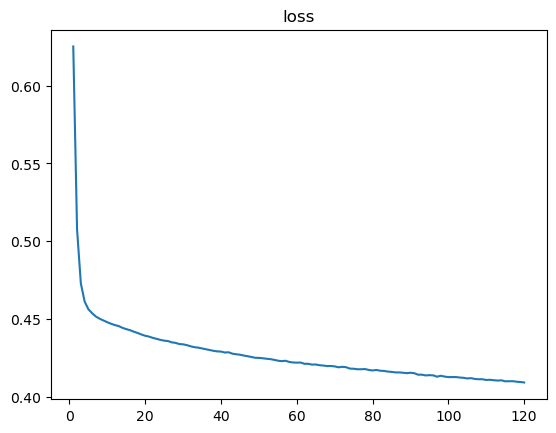

In [59]:
%matplotlib inline
# view loss function
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))
history_df['loss'].plot(title="loss")

In [60]:
# predictions
y_pred = nn.predict(X_test_scaled)
y_pred[0:10]


45/45 [==============================] - 0s 838us/step


array([[0.31851354],
       [0.24260482],
       [0.40004453],
       [0.22349249],
       [0.40004453],
       [0.27363127],
       [0.0560112 ],
       [0.6037108 ],
       [0.48811445],
       [0.86353326]], dtype=float32)

In [61]:
# save model
nn.save("trained_a.h5")

#### Step 5: Optimize

https://albertovaldez5.gitlab.io/data-week-19/build/deeplearning.html#model-optimization-and-keras-tuner